In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib import font_manager
# Add fonts to the plot
font_dirs = ['../otros/lmr']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Latin Modern Roman'
RANDOM_STATE = 17
DATA_SET_NUMBER = 3 # 1,2,3
TYPE_OF_AVG = "rolling" # rolling, or normal
period = 20
result_path = Path("../data/pca_results")
if not result_path.exists():
    result_path.mkdir()

In [4]:
if DATA_SET_NUMBER == 2:
    df = pd.read_pickle("../data/2nd_test_full.pkl")
elif DATA_SET_NUMBER == 3:
    df = pd.read_pickle("../data/3th_test_full.pkl")
else:
    raise ValueError("lol")
df = df.abs()

In [5]:
df = pd.DataFrame({"a":[1,2,3,4]},index = [1,2,3,4])
df1 = pd.DataFrame({"b":[1,2,3,4]},index = [0,2,3,4])
df2 = pd.DataFrame({"c":[17]},index = [1])
dft = df.join(df1)
dft = dft.join(df2)
dft

,a,b,c
1,1,NaN,17.0
2,2,2.0,NaN
3,3,3.0,NaN
4,4,4.0,NaN


In [16]:
def save_fig(fig,fig_name,**kwargs):
    # saves the figure to a common folder
    import os
    if not os.path.exists("figures"):
        os.mkdir("figures")
    fig.savefig(fname= "figures/{}".format(fig_name) , **kwargs)
    
def spree_plot(pca_object,fig_title=None,fig_name = None,**kwargs):
    with plt.style.context("seaborn-paper"):
    # returns a spree plot from a PCA object
        per_var = np.round(pca_object.explained_variance_ratio_* 100, decimals=1)
        labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
        fig, ax = plt.subplots()
        ax.bar(x = range(1,len(per_var)+1),height=per_var, tick_label=labels)
        ax.set_ylabel('Percentage of Explained Variance')
        ax.set_xlabel('Principal Components')
        if fig_title:
            ax.set_title("Scree Plot")
        else:
            ax.set_title(fig_title)
        if fig_name:
            fig.savefig("../scripts/pdf_img/spree_ex.pdf",dpi = 300)

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
        
# caluclate Mahalanobis distance
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

# outlier detection

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

# threshold for the classificiation beyond which is an anomaly

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

# check if matrix is postive definite

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [6]:
# calculate the covariance matrix
def get_cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [7]:
if TYPE_OF_AVG == "rolling":
    df1 = df.groupby("timestamp").mean()
    df1 = df1.rolling(window = period).mean()
    df1.index = pd.to_datetime(df1.index,unit='s')
    df1.dropna(inplace = True)
else:
    df1 = df.groupby("timestamp").mean()
    df1.index = pd.to_datetime(df1.index,unit='s')
    

In [8]:
df1

,b1_ch1,b2_ch2,b3_ch3,b4_ch4
timestamp,,,,
2004-03-04 11:32:46,0.062350,0.074028,0.054567,0.042990
2004-03-04 11:42:46,0.062518,0.074054,0.054721,0.043004
2004-03-04 11:52:46,0.062706,0.074237,0.055029,0.043131
2004-03-04 12:02:46,0.062808,0.074393,0.055192,0.043259
2004-03-04 12:12:46,0.062820,0.074449,0.055305,0.043286
...,...,...,...,...
2004-04-18 00:02:55,0.108956,0.168623,0.298339,0.177392
2004-04-18 00:12:55,0.109467,0.170525,0.303528,0.181849
2004-04-18 00:22:55,0.110311,0.174255,0.312075,0.186023


<AxesSubplot:xlabel='timestamp'>

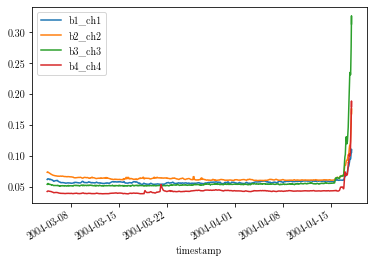

In [9]:
df1.plot()

In [10]:
df1

,b1_ch1,b2_ch2,b3_ch3,b4_ch4
timestamp,,,,
2004-03-04 11:32:46,0.062350,0.074028,0.054567,0.042990
2004-03-04 11:42:46,0.062518,0.074054,0.054721,0.043004
2004-03-04 11:52:46,0.062706,0.074237,0.055029,0.043131
2004-03-04 12:02:46,0.062808,0.074393,0.055192,0.043259
2004-03-04 12:12:46,0.062820,0.074449,0.055305,0.043286
...,...,...,...,...
2004-04-18 00:02:55,0.108956,0.168623,0.298339,0.177392
2004-04-18 00:12:55,0.109467,0.170525,0.303528,0.181849
2004-04-18 00:22:55,0.110311,0.174255,0.312075,0.186023


# Nota
Hay que asegurarse que el split del dataset se hace bien con usando train_test_split  
Tambien he visto una cosa rara con el splitting, la forma en la que hace el pive le da más peso
al test set que al train set. Cosa que no entiendo y pienso que no tiene sentido

In [11]:
if DATA_SET_NUMBER == 2:
    
#X_train, X_test= train_test_split(df1, test_size=0.3, random_state=RANDOM_STATE)
    X_train = df1["2004-02-12 11:02:39":"2004-02-17 23:52:39"] #set 2
    X_test = df1["2004-02-17 23:52:39":] # 2004-02-12 11:02:39 #set 2
elif DATA_SET_NUMBER== 3:
    X_train = df1["2004-04-01 ":"2004-04-08"] #set 3
    X_test = df1["2004-04-08":] # set 3
else:
    raise ValueError("lol")

In [12]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),
                       columns = X_train.columns,
                       index = X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),
                      columns = X_test.columns,
                      index = X_test.index)

In [13]:
n_comp = 4
pca = PCA(random_state = RANDOM_STATE,svd_solver ='full',n_components = n_comp)
labels = [f"PCA{i}" for i in range(1,n_comp+1)]
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA,index =X_train.index,columns = labels )
pca.get_covariance()

array([[ 0.06255597, -0.04113064,  0.01457736,  0.03783582],
       [-0.04113064,  0.05255521, -0.01403508, -0.04394947],
       [ 0.01457736, -0.01403508,  0.03563414,  0.01782128],
       [ 0.03783582, -0.04394947,  0.01782128,  0.05425019]])

In [14]:
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA,index = X_test.index,columns = labels)
pca.get_covariance()

array([[ 0.06255597, -0.04113064,  0.01457736,  0.03783582],
       [-0.04113064,  0.05255521, -0.01403508, -0.04394947],
       [ 0.01457736, -0.01403508,  0.03563414,  0.01782128],
       [ 0.03783582, -0.04394947,  0.01782128,  0.05425019]])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
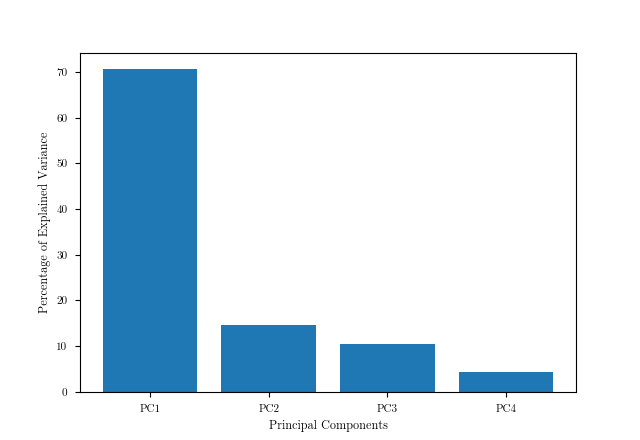

In [19]:
#latex:lol
%matplotlib widget
spree_plot(pca,fig_name="lol")

Text(0, 0.5, 'PC2 - 14.6%')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
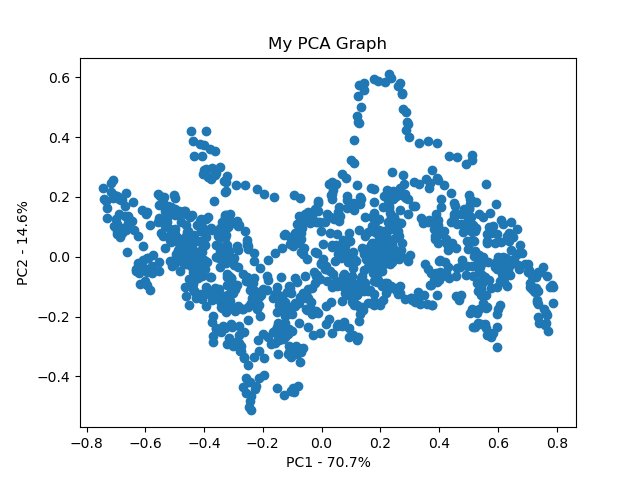

In [296]:
fig, ax = plt.subplots()
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
ax.scatter(X_train_PCA.PCA1, X_train_PCA.PCA2)
ax.set_title('My PCA Graph')
ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))

In [297]:
cov_matrix, inv_cov_matrix = get_cov_matrix(X_train_PCA.values)

In [298]:
cov_matrix, inv_cov_matrix  = pca.get_covariance()[0:2,0:2], np.linalg.inv(pca.get_covariance()[0:2,0:2])

In [299]:
X_train_PCA.mean(axis = 0)

PCA1    3.972002e-18
PCA2   -2.767081e-17
dtype: float64

In [300]:
dist_test = MahalanobisDist(inv_cov_matrix, X_train_PCA.mean(axis = 0).values, X_test_PCA.values)
dist_train = MahalanobisDist(inv_cov_matrix, X_train_PCA.mean(axis = 0).values, X_train_PCA.values)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
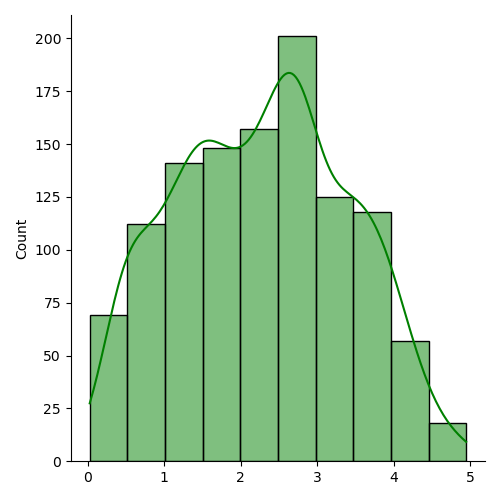

In [301]:
%matplotlib widget
# add kde plot to Malabist distance
sns.displot(dist_train,bins = 10,kde = True,color = "green")

In [302]:
threshold = MD_threshold(dist_train, extreme = False)

In [303]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()
anomaly_alldata = pd.concat([anomaly_train, anomaly])

,Mob dist,Thresh,Anomaly
timestamp,,,
2004-04-08 00:01:57,2.733143,4.569385,False
2004-04-08 00:11:57,2.790107,4.569385,False
2004-04-08 00:21:57,2.827607,4.569385,False
2004-04-08 00:31:57,2.760730,4.569385,False
2004-04-08 00:41:57,2.767986,4.569385,False


In [305]:
if TYPE_OF_AVG == "rolling":
    path_to_save = result_path/f"pca_data_{TYPE_OF_AVG}_{period}_{DATA_SET_NUMBER}.pkl"
else:
    path_to_save = result_path/f"pca_data_{TYPE_OF_AVG}_{DATA_SET_NUMBER}.pkl"
anomaly_alldata.to_pickle(str(path_to_save))